# <font color='black'>Spaceship Titanic</font>

## <font color='red'>Predict which passengers are transported to an alternate dimension</font>

### Task: It's to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly.

## Dataset Exploration 

In [1]:
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
# Initialize randomness
random_state = 0 

# Data loading
data = pd.read_csv(r"C:\Users\Lukas\Documents\Data Science\Projetos\spaceship-titanic\train.csv")
submission_data = pd.read_csv(r"C:\Users\Lukas\Documents\Data Science\Projetos\spaceship-titanic\test.csv")

display(data.head())
print(f'Data include {len(data.columns)} features')
print(f'Labeled   data is made of {len(data)} samples')
print(f'Unlabeled data is made of {len(submission_data)} samples\n')

missing_percentage = data.isnull().sum() / len(data)
print(f'Percentage of missing values within data columns:')
(100 * missing_percentage).round(2).astype('str') + '%'

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Data include 14 features
Labeled   data is made of 8693 samples
Unlabeled data is made of 4277 samples

Percentage of missing values within data columns:


PassengerId      0.0%
HomePlanet      2.31%
CryoSleep        2.5%
Cabin           2.29%
Destination     2.09%
Age             2.06%
VIP             2.34%
RoomService     2.08%
FoodCourt       2.11%
ShoppingMall    2.39%
Spa             2.11%
VRDeck          2.16%
Name             2.3%
Transported      0.0%
dtype: object

In [4]:
print('Statistics of categoric columns')
display(data.select_dtypes('object').describe())
print(f'There are {data.duplicated().sum()} duplicated rows')

Statistics of categoric columns


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


There are 0 duplicated rows


The first two columns however, serve the only purpose of passengers identification and should not be taken into account during features analysis. Moreover, in the data description it is reported that the column "Cabin" actually carries three separate informations, which can be split into three new columns: "Deck", "Num", "Side".

## Feature Engineering 

The first thing I'll deal with is feature engineering because there are hints on how to perform it and it helps conducting a cleaner feature analysis. The changes implemented will be:

Extract "PassengerId" into "Group", "GroupNum"
Split "Cabin" into "Deck", "Num", "Side"
Shift the meaning of the new column "Side" into "SidePort" to encode it as a binary variable. Its state will be True if the cabin is on the Port side, False if it's on the Starboard side
Define a new column "Bills" to account for the overall expenses
Drop the following columns: "PassengerId", "Group", "Cabin", "Side", "Name"
For the sake of code simplicity I will also impute some of the missing values. Since from data description passengers put in suspended animation are confined to their cabin, their expenses at the spaceship services will be none.

In [6]:
def custom_features(data):
    df = data.copy()
    to_drop = ['PassengerId', 'Group', 'Cabin', 'Side', 'Name']
    bill_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df.loc[(df['CryoSleep'] == True), bill_cols ] = df.loc[(df['CryoSleep']==True),bill_cols].fillna(0)
    
    # Features extraction 
    df['Bills'] =df[bill_cols].sum(axis=1, skipna=False)
    df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype('float')
    df['GroupNum'] = df['PassengerId'].apply(lambda x: x.split('_')[1]).astype('float')
    df['Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0] if pd.notna(x) else np.nan)
    df['Num']  = df['Cabin'].apply(lambda x: x.split('/')[1] if pd.notna(x) else np.nan).astype('float')
    df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[2] if pd.notna(x) else np.nan)
    df['SidePort'] = df['Side'].replace({'P': True, 'S': False})
    df = df.drop(columns=to_drop)
    return df

In [9]:
df = data.drop(columns='Transported')
df = custom_features(df)
y = data['Transported']

display(df.head())
print(f'Engineered data contain {len(df.columns)} features\n')
print('Statistics of categoric columns')
display(df.select_dtypes('object').describe())
print('Statistics of numeric columns')
display(df.select_dtypes('float').describe())
new_missing_percentage = df.isnull().sum() / len(df)
print(f'Percentage of missing values after first imputation:')
(100 * new_missing_percentage).round(2).astype('str') + '%'

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Bills,GroupNum,Deck,Num,SidePort
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B,0.0,True
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,736.0,1.0,F,0.0,False
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,10383.0,1.0,A,0.0,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,5176.0,2.0,A,0.0,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1091.0,1.0,F,1.0,False


Engineered data contain 15 features

Statistics of categoric columns


,HomePlanet,CryoSleep,Destination,VIP,Deck,SidePort
count,8492,8476,8511,8490,8494,8494
unique,3,2,3,2,8,2
top,Earth,False,TRAPPIST-1e,False,F,False
freq,4602,5439,5915,8291,2794,4288


Statistics of numeric columns


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Bills,GroupNum,Num
count,8514.000000,8580.000000,8580.000000,8581.000000,8575.000000,8567.000000,8132.000000,8693.000000,8494.000000
mean,28.827930,222.906876,454.339977,171.785573,308.780292,302.648535,1421.252213,1.517773,600.367671
std,14.489021,664.368930,1605.430304,601.581625,1132.710170,1141.855811,2800.039209,1.054241,511.867226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,167.250000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,705.000000,1.000000,427.000000
75%,38.000000,44.000000,70.000000,24.000000,58.000000,44.000000,1402.250000,2.000000,999.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000,8.000000,1894.000000


Percentage of missing values after first imputation:


HomePlanet      2.31%
CryoSleep        2.5%
Destination     2.09%
Age             2.06%
VIP             2.34%
RoomService      1.3%
FoodCourt        1.3%
ShoppingMall    1.29%
Spa             1.36%
VRDeck          1.45%
Bills           6.45%
GroupNum         0.0%
Deck            2.29%
Num             2.29%
SidePort        2.29%
dtype: object

## Relations with the target 

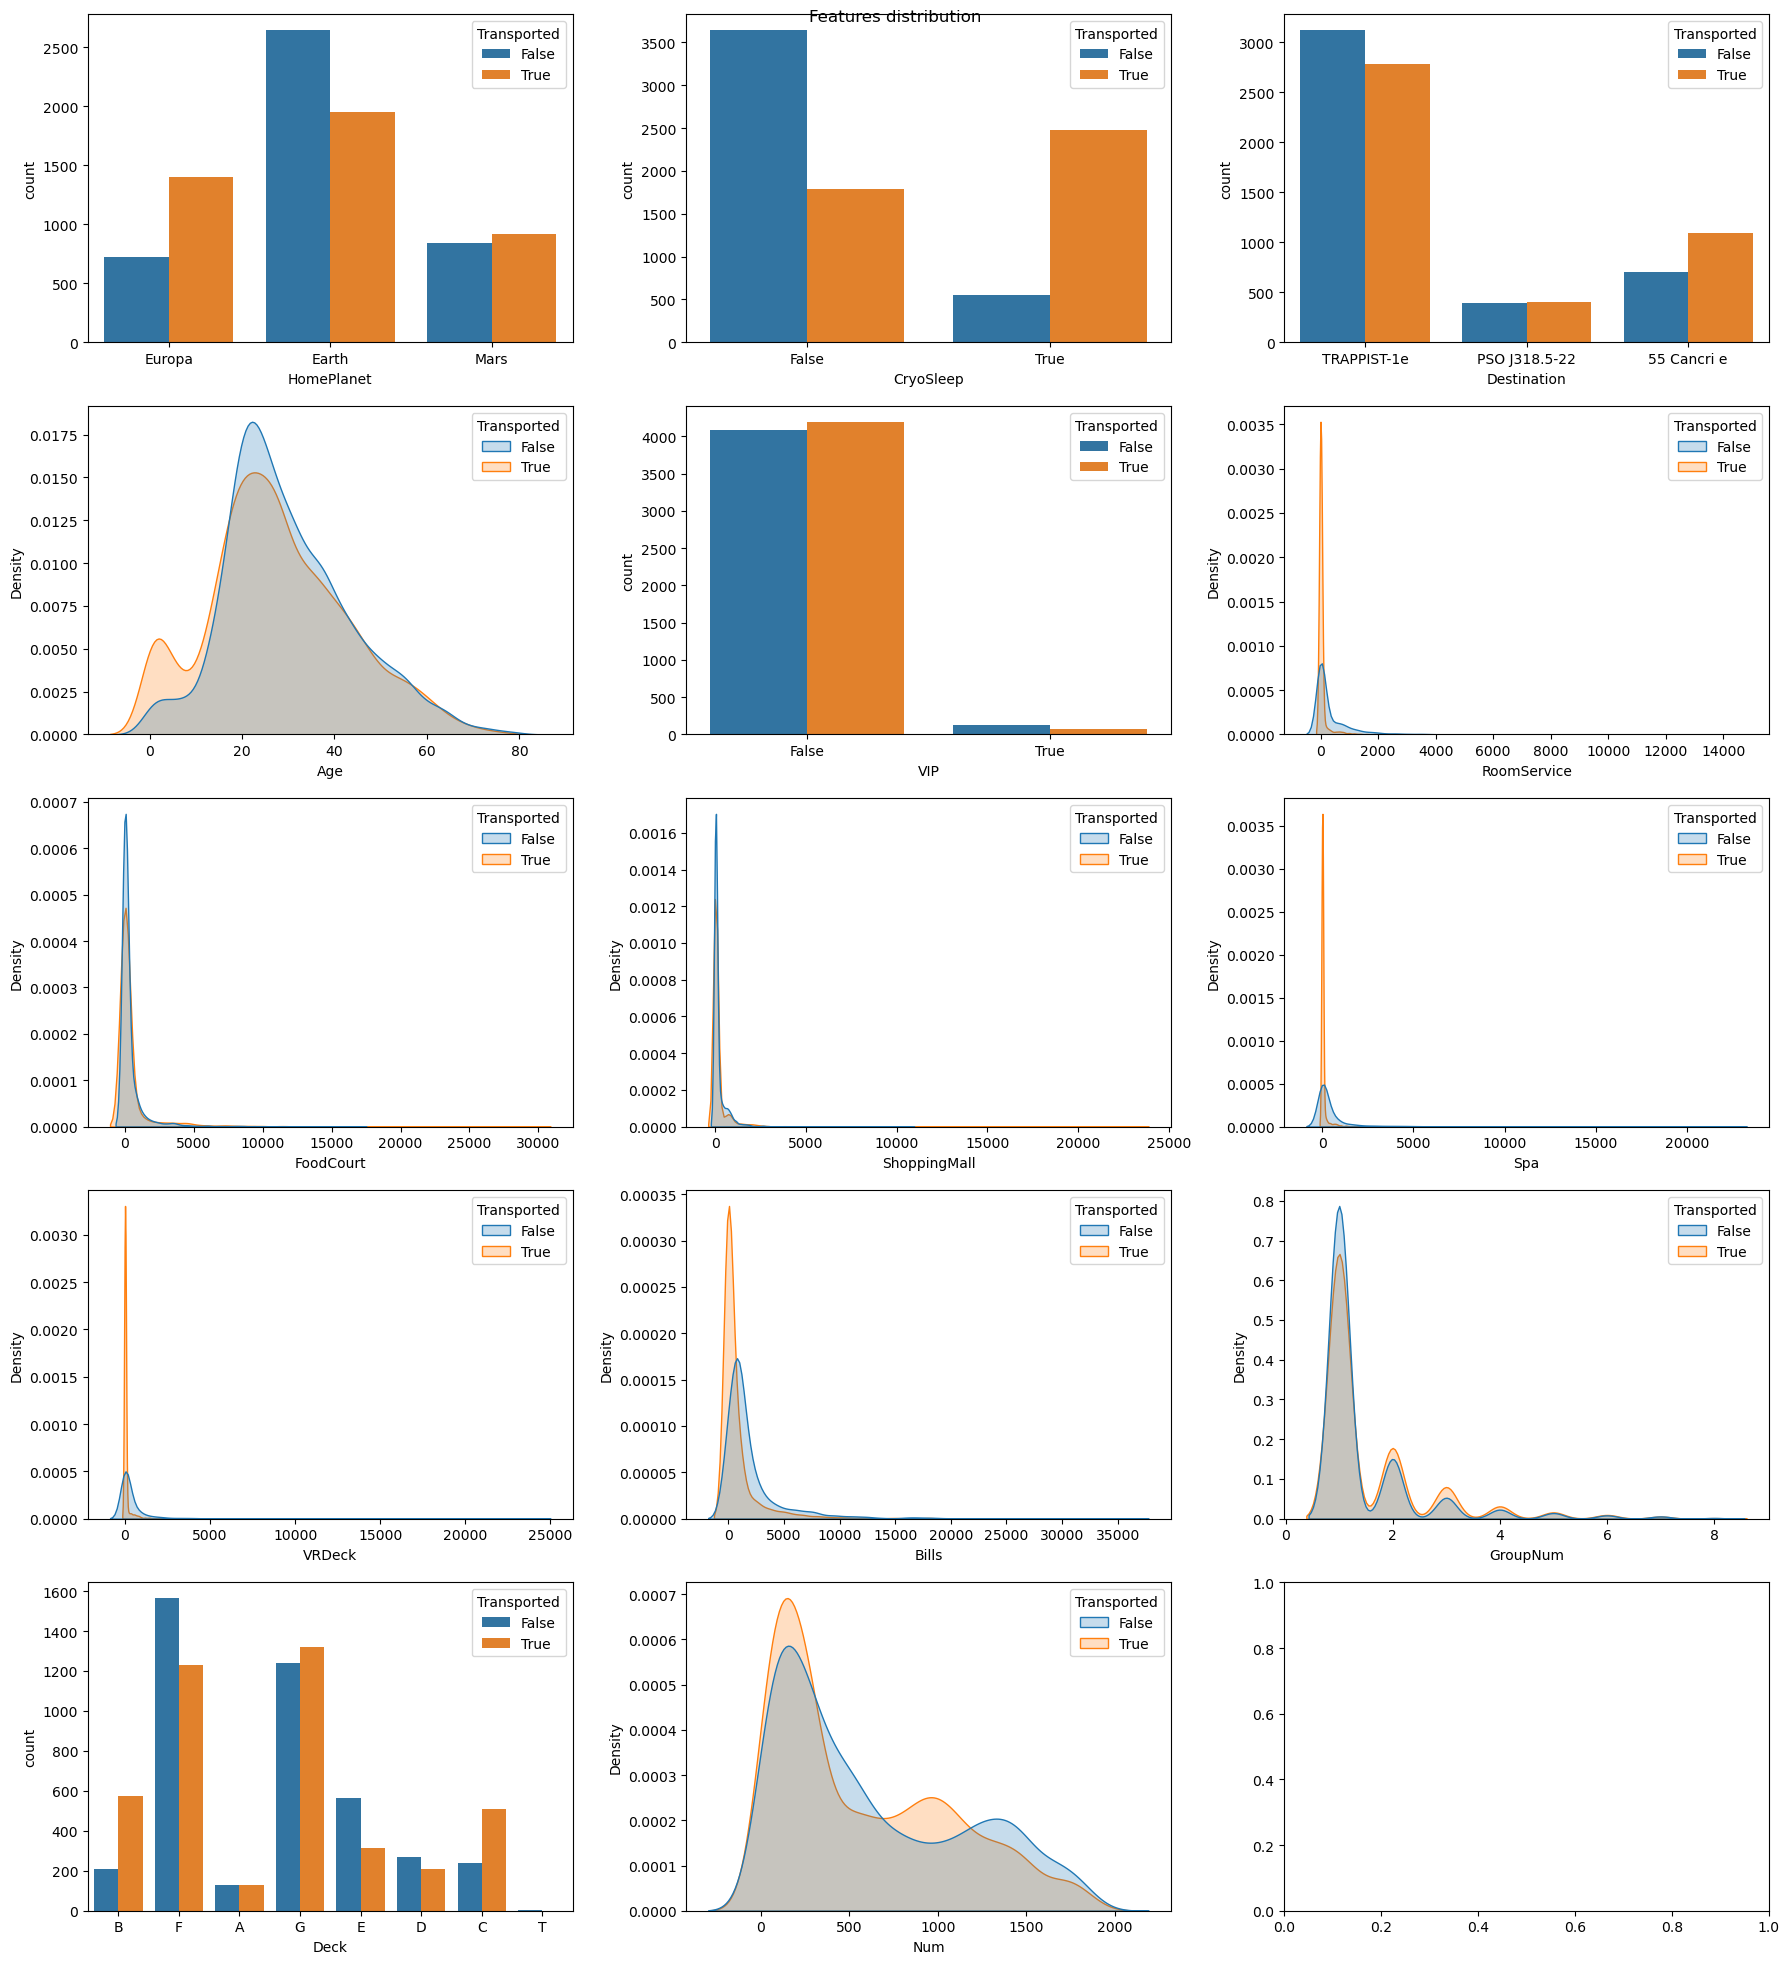

Number of     transported passegners = 4378
Number of non-transported passegners = 4315


In [16]:
ncols = 3 
nrows = math.ceil(len(df.columns)//ncols)
fig, axs= plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))

for j, col in enumerate(df.columns[:-1]):
    ax = axs[j//ncols, j%ncols]
    if col in df.select_dtypes('float').columns:
        sns.kdeplot(ax=ax, x=df[col], hue=y, fill=True)
    else:
        sns.countplot(ax=ax, x=df[col], hue=y)
plt.suptitle('Features distribution')
fig.tight_layout()
plt.show()

print(f'Number of     transported passegners = {y.value_counts()[True]}')
print(f'Number of non-transported passegners = {y.value_counts()[False]}') 

## Preprocessing and correlation
* Encoding categorical features
* Apply proper numeric transformations
* Impute missing values

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [20]:
numerical_cols = df.select_dtypes('float').columns
categorical_cols = df.select_dtypes('object').columns

transformer = ColumnTransformer(
    transformers = [('encoder', OrdinalEncoder(), categorical_cols),
                   ('placeholder', FunctionTransformer(lambda x:x),numerical_cols),])
preprocessor = Pipeline(steps=[
    ('encoder', transformer),
    ('scaler', MinMaxScaler()),
    ('imputer', IterativeImputer(KNeighborsRegressor(n_neighbors=1)))
])

df_pre = pd.DataFrame(preprocessor.fit_transform(df), columns=list(categorical_cols) + list(numerical_cols))
df_pre = df_pre.reindex(columns=df.columns)
df_pre.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Bills,GroupNum,Deck,Num,SidePort
0,0.5,0.0,1.0,0.493671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,1.0
1,0.0,0.0,1.0,0.303797,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,0.020452,0.000000,0.714286,0.000000,0.0
2,0.5,0.0,1.0,0.734177,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.288521,0.000000,0.000000,0.000000,0.0
3,0.5,0.0,1.0,0.417722,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.143830,0.142857,0.000000,0.000000,0.0
4,0.0,0.0,1.0,0.202532,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,0.030317,0.000000,0.714286,0.000528,0.0


Now that the our data are finally in a numeric format we can look at them in a global form through algebraic techniques, such as PCA.

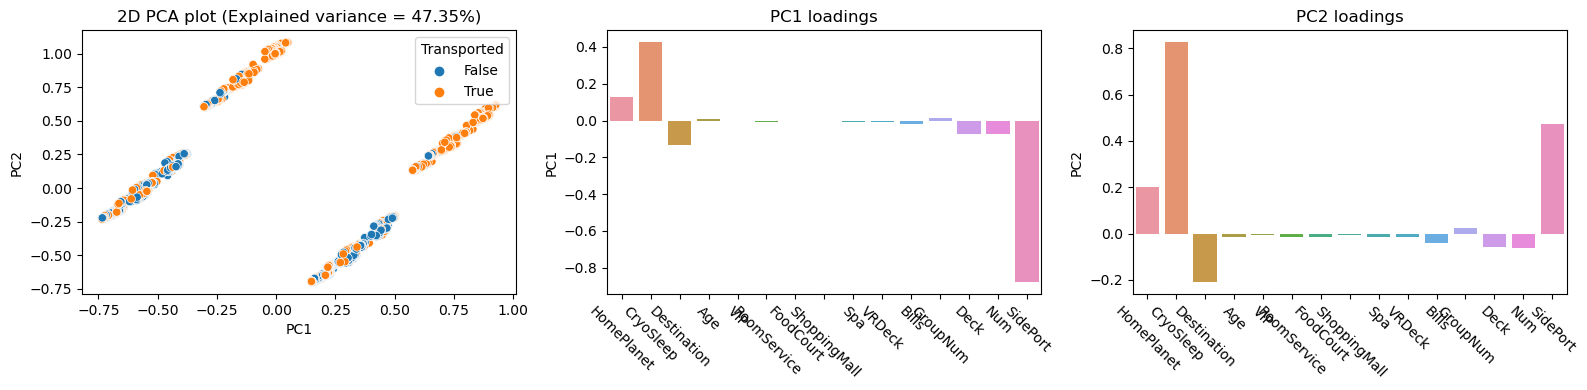

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
pca_columns = ['PC'+str(i+1) for i in range(pca.n_components)]
X_pca = pd.DataFrame(pca.fit_transform(df_pre), columns=pca_columns)
pca_components = pd.DataFrame(pca.components_, columns=df_pre.columns, index=pca_columns)

# PCA plot
fig, axs = plt.subplots(1, 3, figsize=(16,4))
sns.scatterplot(ax=axs[0], data=X_pca, x='PC1', y='PC2', hue=y.astype(bool))
axs[0].set_title(f'2D PCA plot (Explained variance = {round(100 * pca.explained_variance_ratio_[:2].sum(), 2)}%)')
sns.barplot(ax=axs[1], x=pca_components.columns, y=pca_components.loc['PC1'])
sns.barplot(ax=axs[2], x=pca_components.columns, y=pca_components.loc['PC2'])
axs[1].tick_params(axis='x', labelrotation=-45)
axs[2].tick_params(axis='x', labelrotation=-45)
axs[1].set_title('PC1 loadings')
axs[2].set_title('PC2 loadings')
fig.tight_layout()
plt.show()

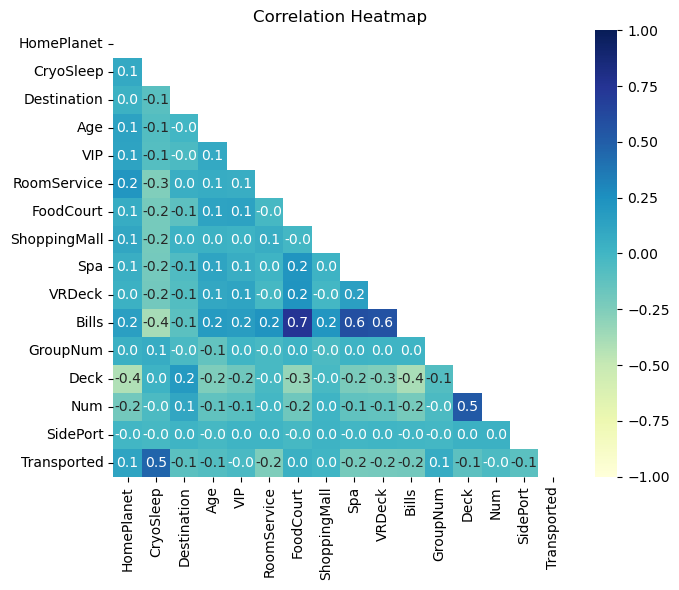

In [22]:
# Correlation matrix
fig = plt.figure(figsize=(7,6))
corr = pd.concat([df_pre, y], axis=1).corr()
sns.heatmap(corr, annot=True, fmt='.1f', mask=np.triu(corr), cmap='YlGnBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
fig.tight_layout()
plt.show()


### Observations:
* "Bills" is negatively correlated to "CroSleep" since passengers sleeping are not getting out of their room. The high positive correlation with expenses features is due to the fact that this column have been engineered as their sum
* "Transported" is positively correlated to "CryoSleep", which is a pattern we already observed in the previous section

## Modeling

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

# define pipeline
pipeline = Pipeline(steps=[
    ('engineering', FunctionTransformer(custom_features)),
    ('preprocessing', preprocessor)
])

# apply pipeline
X = pd.DataFrame(pipeline.fit_transform(data.drop(columns='Transported')),
                 columns=df_pre.columns)

# split train-validation data
test_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=test_size,stratify=y,shuffle=True,random_state=random_state)

print(f'Size of training   set = {len(X_train)}')
print(f'Size of valdiation set = {len(X_val)}')

Size of training   set = 6954
Size of valdiation set = 1739


In [32]:

!pip install xgboost

class MultiClassifier:
    def __init__(self, models_list=None, random_state=0,
                 n_jobs=-1, verbose=0):
        
        self.models_list = models_list
        self.random_state = random_state
        self.n_jobs = -1
        self.verbose = verbose
        self.allocate_models()
        
    
    # Creates an estimator for each model in models_list and append it to allocated_models
    def allocate_models(self):
        self.allocated_models = []
        for model in self.models_list:
            match model:
                case 'XGBClassifier':
                    from xgboost import XGBClassifier
                    estimator = XGBClassifier(random_state=self.random_state, n_jobs=self.n_jobs)
                case 'RandomForestClassifier':
                    from sklearn.ensemble import RandomForestClassifier
                    estimator = RandomForestClassifier(random_state=self.random_state, n_jobs=self.n_jobs)
                case 'MLPClassifier':
                    from sklearn.neural_network import MLPClassifier
                    estimator = MLPClassifier(hidden_layer_sizes=[4], random_state=self.random_state)
                case 'SVC':
                    from sklearn.svm import SVC
                    estimator = SVC(random_state=self.random_state, probability=True)
                case 'KNeighborsClassifier':
                    from sklearn.neighbors import KNeighborsClassifier
                    estimator = KNeighborsClassifier(n_jobs=self.n_jobs)
                case 'GaussianNB':
                    from sklearn.naive_bayes import GaussianNB
                    estimator = GaussianNB()
                case 'LogisticRegression':
                    from sklearn.linear_model import LogisticRegression
                    estimator = LogisticRegression(random_state=self.random_state)
            self.allocated_models.append(estimator)
    
    # Set estimators parameters through a dictionary pms with keys matching models_list
    def set_parameters(self, pms):
        for model_name, estimator in zip(self.models_list, self.allocated_models):
            if model_name in pms:
                estimator.set_params(**pms[model_name])

    # Allocates models and fit them on X, y
    def fit(self, X, y):
        for model in self.allocated_models:
            t0 = time.time()
            if self.verbose != 0:
                print(f'--> Fitting model {model.__class__.__name__}...')
            model.fit(np.array(X), y)
            if self.verbose != 0:
                print(f'Process completed in {round(time.time() - t0, 2)}s')
    
    # Predict target values for X data according to the voting strategy
    def predict(self, X, voting=None, weight_models=None):
        try:    preds = pd.DataFrame(columns=self.models_list, index=X.index)  # if X is df preserve index
        except: preds = pd.DataFrame(columns=self.models_list)
        
        for model in self.allocated_models:
            model_name = model.__class__.__name__
            preds[model_name] = model.predict(np.array(X))

        # Generate prediction according to the voting system
        match voting:
            case 'majority':
                weights = 1 / len(self.models_list)
                preds = (weights * preds).sum(axis=1)
            case 'weighted':
                weights = pd.Series(0, self.models_list)
                weights[weight_models] = 1
                weights = weights / weights.sum()
                preds = (weights * preds).sum(axis=1)
            case None:
                pass
            
        preds = preds.round().astype(bool)
        return preds

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 825.8 kB/s eta 0:02:01
   ---------------------------------------- 0.2/99.8 MB 1.7 MB/s eta 0:00:59
   ---------------------------------------- 0.5/99.8 MB 3.3 MB/s eta 0:00:31
    --------------------------------------- 1.4/99.8 MB 6.7 MB/s eta 0:00:15
   - -------------------------------------- 2.8/99.8 MB 11.0 MB/s eta 0:00:09
   -- ------------------------------------- 5.3/99.8 MB 17.9 MB/s eta 0:00:06
   --- ------------------------------------ 8.0/99.8 MB 23.3 MB/s eta 0:00:04
   ---- ----------------------------------- 10.5/99.8 MB 36.4 MB/s eta 0:00:03
   ----- -----------------------

--> Fitting model XGBClassifier...
Process completed in 0.08s
--> Fitting model RandomForestClassifier...
Process completed in 0.27s
--> Fitting model KNeighborsClassifier...
Process completed in 0.01s
--> Fitting model GaussianNB...
Process completed in 0.0s
--> Fitting model SVC...
Process completed in 4.87s
--> Fitting model MLPClassifier...


C:\Users\Lukas\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Process completed in 0.93s


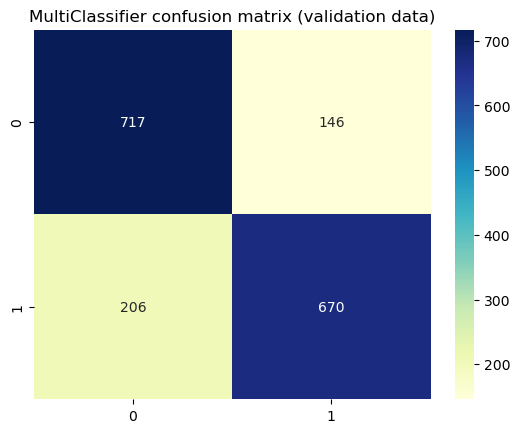

Training   accuracy = 0.8923
Validation accuracy = 0.7976


In [33]:
models_list = [
    'XGBClassifier',
    'RandomForestClassifier',
    'KNeighborsClassifier',
    'GaussianNB',
   # 'LogisticRegression',
    'SVC',
    'MLPClassifier',
]

# Instanciating and fitting
clf_0 = MultiClassifier(models_list, random_state=random_state, verbose=1)
clf_0.fit(X_train, y_train)
# Model evaluation
y_train_0 = clf_0.predict(X_train, voting='majority')
y_val_0   = clf_0.predict(X_val,   voting='majority')
sns.heatmap(confusion_matrix(y_val, y_val_0), annot=True, fmt='d', cmap='YlGnBu')
plt.title('MultiClassifier confusion matrix (validation data)')
plt.show()

print(f'Training   accuracy = {round(accuracy_score(y_train, y_train_0), 4)}')
print(f'Validation accuracy = {round(accuracy_score(y_val,   y_val_0),   4)}')

In [34]:
train_preds_0 = clf_0.predict(X_train)
val_preds_0   = clf_0.predict(X_val)

scores = pd.DataFrame(index=models_list, columns=['Train', 'Val'])
scores['Train'] = [accuracy_score(y_train, train_preds_0[name]) for name in scores.index]
scores['Val']   = [accuracy_score(y_val,   val_preds_0[name])   for name in scores.index]
scores = scores.round(4)
scores.sort_values(by="Train", ascending=False)

,Train,Val
RandomForestClassifier,0.9984,0.7987
XGBClassifier,0.9475,0.7993
KNeighborsClassifier,0.8261,0.7389
MLPClassifier,0.7892,0.7838
SVC,0.7741,0.7654
GaussianNB,0.6997,0.6797


* XGB, RandomForest and MLP achieves the highest score, reaching 79% accuracy on the validation set
* Among the other models considered, Naive-Bayes performs especially bad (68% accuracy on the validation set)
* RandomForest, XGB and KNN are the models responsible for the overfitting

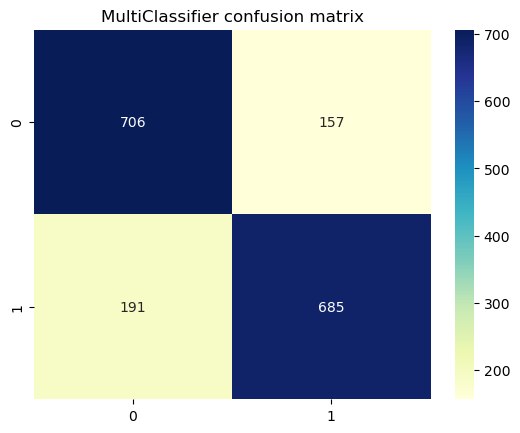

Training   accuracy = 0.8312
Validation accuracy = 0.7999


,Train,Val
XGBClassifier,0.8451,0.8056
RandomForestClassifier,0.8376,0.7890
MLPClassifier,0.8095,0.7907
SVC,0.8076,0.7901
KNeighborsClassifier,0.7893,0.7585
GaussianNB,0.6997,0.6797


In [35]:
custom_hyperparameters = {
    'XGBClassifier': {'learning_rate': 0.1,
                      'max_depth': 4},
    'RandomForestClassifier': {'max_depth': 10,
                               'ccp_alpha': 0.0005},
    'KNeighborsClassifier': {'n_neighbors': 15},
    'MLPClassifier' : {'hidden_layer_sizes' : [8, 4],
                       'max_iter' : 500},
    'SVC' : {'C' : 10}
}
    
clf_1 = MultiClassifier(models_list, random_state=random_state, verbose=0)
clf_1.set_parameters(custom_hyperparameters)
clf_1.fit(X_train, y_train)
# Model evaluation
y_train_1 = clf_1.predict(X_train, voting='majority')
y_val_1   = clf_1.predict(X_val,   voting='majority')
sns.heatmap(confusion_matrix(y_val, y_val_1), annot=True, fmt='d', cmap='YlGnBu')
plt.title('MultiClassifier confusion matrix')
plt.show()

train_preds_1 = clf_1.predict(X_train)
val_preds_1   = clf_1.predict(X_val)

print(f'Training   accuracy = {round(accuracy_score(y_train, y_train_1), 4)}')
print(f'Validation accuracy = {round(accuracy_score(y_val,   y_val_1),   4)}')

scores = pd.DataFrame(index=models_list, columns=['Train', 'Val'])
scores['Train'] = [accuracy_score(y_train, train_preds_1[name]) for name in scores.index]
scores['Val']   = [accuracy_score(y_val,   val_preds_1[name])   for name in scores.index]
scores = scores.round(4)
display(scores.sort_values(by="Train", ascending=False))